[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MNoichl/simple_teams/blob/main/tr_pd_network_new_games.ipynb)

# Team-reasoning in the Prisoners-Dilemma 

This notebook implements a simulation of the PD game using mesa. In the simulation, agents, which are either team-reasoners or not, are randomly assigned other players, with whom they play the PD. Their strategy is hereby determined as follows:

![tree.png](tree.png)

In [1]:
# !pip install svgling
# !pip install cairosvg
import svgling
from cairosvg import svg2png
qrtree1 = (
    "Player is...",
    (
        "...team-reasoner",
        ("with p: team-reason", "cooperate"),
        ("with 1-p: don't team reason", ("defect")),
    ),
    ("...normal player", ("defect")),
)
svg2png(bytestring=svgling.draw_tree(qrtree1)._repr_svg_(), write_to="tree.png")


## To-Do

Here are a view improvements and additions that might be made to the code:
1. Pairwise scheduling of agents? (Via one agent!)
1. error handling für keine Team-reasoner mehr.
1. Replicator dynamics [Leyla will tell me] 
2. Add different games 
2. Multiple games
3. Endogenize probability through bayesian learning
4. Put agents eg. on networks
5. different matrix for learning of TRs? 

In [6]:
# uncomment these lines below, when running in colab:
# !pip install nashpy==0.0.20
# !pip install mesa
# !pip install cmcrameri # extra colormaps
# !pip install floweaver
# !pip install ipysankeywidget
!jupyter nbextension enable --py --sys-prefix ipysankeywidget
!jupyter nbextension enable --py --sys-prefix widgetsnbextension


# !git clone https://github.com/MNoichl/simple_teams
# %cd simple_teams


# game-theoretic:
import nashpy as nash

# mesa:
from mesa import Agent, Model
from mesa.time import RandomActivation, BaseScheduler
from mesa.datacollection import DataCollector

# standards:
import numpy as np
import pandas as pd
import tqdm

# graphics:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate

from cmcrameri import cm
import cmocean

import networkx as nx



# code formatting – comment out when using colab:
%load_ext nb_black
%config IPCompleter.greedy=True


Enabling notebook extension jupyter-sankey-widget/extension...
      - Validating: ok


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


<IPython.core.display.Javascript object>

## Define some games

Issues:
* currently choices start at 1 in the graphic and at 0 when computing.
* currently we are calculating strategies during the simulation. Unsurprisingly, this is **horrible** for performance.

In [73]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

# https://github.com/anjalika-nande/dynamics_sim hmmmm?


def random_argmax(b):
    """Returns the position of the maximum element, or a random one of multiple maxima, if present:
    basically argmax with tiebreaking.

    Args:
        b (list or array):

    Returns:
        int: position of chosen maximum
    """
    return np.random.choice(np.flatnonzero(b == np.max(b)))


class game:

    """An game-class to set up and visualize games.

    Attributes:
        name (str): name of the game. maybe useful to keep track of things.
        n_players (int): number of the players in the game.
        n_choices (int): number of choices for the players. This class currently supports
            games with assymmetric payoffs, but not games with unequal numbers of choices.
            Somebody could implement that.
        payoffs (list): list of lists with length n_players**n_choices.
            Each item of payoffs is a list of the payoffs for each player
            under the a certain configuration. The order is important.
        size (dict): Size of the frame in which the game gets shown. Form: dict(width=2200, height=1570)
    """

    def __init__(
        self,
        name="prisoners_dilemma",
        n_players=2,
        n_choices=2,
        payoffs=[[2, 2], [0, 0], [0, 0], [1, 1]],
        size=dict(width=2200, height=1570),
    ):

        self.name = name
        self.n_players = n_players
        self.n_choices = n_choices

        #         self.choice_labels
        self.tree = nx.balanced_tree(
            n_choices, n_players
        )  # This limits us to games with symmetric numbers of choices!
        self.payoffs = payoffs
        self.size = size
        self.path_array = self.get_path_array()

    def show_game(self):
        """
        Plots the defined game as a Sankey diagram.
        """
        T = self.tree
        distances_to_origin = []
        for node in T.nodes():
            distances_to_origin.append(len(nx.shortest_path(T, source=0, target=node)))

        T_edges = T.edges(data=False)
        levels = [distances_to_origin[x[0]] for x in T_edges]

        widths = []
        val = 1
        for k in range(0, self.n_players):
            val = val * self.n_choices
            widths.append(val)

        values = [widths[np.max(levels) - x] for x in levels]
        # values = [(np.max(level) - x) * branches for x in level]

        choice_counter = 1
        payoff_counter = 0
        for node, level in zip(list(T.nodes()), distances_to_origin):
            #     print(node)
            #     print(level-1)
            if level == 1:
                T = nx.relabel_nodes(T, {node: "(" + str(node) + ") init"}, copy=True)
            if level > 1 and level != np.max(distances_to_origin):
                T = nx.relabel_nodes(
                    T,
                    {
                        node: "("
                        + str(node)
                        + ") Player: "
                        + str(level - 1)
                        + ", Choice: "
                        + str(choice_counter)
                    },
                    copy=True,
                )
                #         print('Player: ' + str(level-1)+', Choice: ' + str(choice_counter))
                choice_counter += 1
                if choice_counter > self.n_choices:
                    choice_counter = 1
            if level == np.max(distances_to_origin):
                T = nx.relabel_nodes(
                    T,
                    {
                        node: "("
                        + str(node)
                        + ") Player: "
                        + str(level - 1)
                        + ", Choice: "
                        + str(choice_counter)
                        + " ["
                        + ", ".join([str(x) for x in self.payoffs[payoff_counter]])
                        + "]"
                    },
                    copy=True,
                )
                choice_counter += 1
                payoff_counter += 1
                if choice_counter > self.n_players:
                    choice_counter = 1

        sankey_df = pd.DataFrame(
            np.array(T.edges(data=False)), columns=["source", "target"]
        )
        sankey_df["value"] = values

        layout = Layout(width=str(self.size["width"]), height=str(self.size["height"]))
        display(
            SankeyWidget(
                width=self.size["width"],
                height=self.size["height"],
                links=sankey_df.to_dict("records"),
                margins=dict(top=0, bottom=0, left=50, right=300),
                layout=layout,
            )
        )

    def get_path_array(self):
        paths = []
        for node in self.tree:
            if self.tree.degree(node) == 1:  # it's a leaf
                paths.append(nx.shortest_path(self.tree, 0, node))
        paths = np.array(paths)[:, 1:]

        #         choice_counter = 1
        for column in range(paths.shape[1]):
            unique = np.unique(paths[:, column])
            choice_counter = 1
            for un in unique:
                paths[paths[:, column] == un, column] = choice_counter
                choice_counter += 1
                if choice_counter > self.n_choices:
                    choice_counter = 1
        return paths

    def return_payoffs(self, choices_to_check):

        return self.payoffs[
            np.where(np.all(np.array(choices_to_check) == self.path_array, axis=1))[0][
                0
            ]
        ]

    def return_team_reasoners_choice(self, mode="first"):

        if mode == "first":
            return np.argmax(np.mean(np.array(self.payoffs), axis=1))

        elif mode == "random":
            return random_argmax(np.mean(np.array(self.payoffs), axis=1))

        elif mode == "multiple":
            b = np.mean(np.array(self.payoffs), axis=1)
            return np.flatnonzero(b == np.max(b))

    def return_players_matrix(self, player=0):
        """
        Returns a payoff-matrix for the player, indexed starting with 0.
        Not 100% sure, whether it's already correct...
        """
        return np.array(self.payoffs)[:, player].reshape(
            tuple([self.n_choices] * self.n_players)
        )

    def return_nashpy_equilibrium(self):
        if self.n_players == 2:
            this_game = nash.Game(
                self.return_players_matrix(0), self.return_players_matrix(1)
            )

            return list(this_game.support_enumeration())

        else:
            return "Equilibria for a n_players != 2 are not yet implemented."

    def return_non_trs_choice(self, mode="first"):
        """
        returns indices of the choice(s) of a non-team-reasoner
        """
        eq = self.return_nashpy_equilibrium()
        if isinstance(eq, str):
            return eq
        else:
            if mode == "first":
                return np.argmax(eq)

            elif mode == "random":
                return random_argmax(eq)

            elif mode == "multiple":
                return np.flatnonzero(b == np.max(eq))


HiLo = game(
    name="HiLo",
    n_players=2,
    n_choices=2,
    payoffs=[[2, 2], [0, 0], [0, 0], [1, 1]],
    size=dict(width=1100, height=570),
)

HiLo.show_game()

print(HiLo.return_payoffs([2, 2]))
print(HiLo.return_team_reasoners_choice())
print(HiLo.return_non_trs_choice())

SankeyWidget(layout=Layout(height='570', width='1100'), links=[{'source': '(0) init', 'target': '(1) Player: 1…

[1, 1]
0
0


<IPython.core.display.Javascript object>

In [88]:
prisoners_dilemma = game(
    name="prisoners_dilemma",
    n_players=2,
    n_choices=2,
    payoffs=[[3, 3], [1, 4], [4, 1], [2, 2]],
    size=dict(width=1100, height=570),
)

prisoners_dilemma.show_game()
print(prisoners_dilemma.return_payoffs([1,1]))

print(prisoners_dilemma.return_team_reasoners_choice())
print(prisoners_dilemma.return_non_trs_choice())


SankeyWidget(layout=Layout(height='570', width='1100'), links=[{'source': '(0) init', 'target': '(1) Player: 1…

[3, 3]
0
1


<IPython.core.display.Javascript object>

In [80]:
public_good_payoffs = [[-0.3, -0.3, -0.3, -0.3]] * (2 ** 4)
public_good_payoffs[0] = [0.3 * 4] * 4

public_good_game = game(
    name="public_good_game",
    n_players=4,
    n_choices=2,
    payoffs=public_good_payoffs,
    size=dict(width=1400, height=1070),
)

public_good_game.show_game()
print(public_good_game.return_payoffs([1, 1, 1, 2]))
print(public_good_game.return_team_reasoners_choice())
print(public_good_game.return_non_trs_choice())


SankeyWidget(layout=Layout(height='1070', width='1400'), links=[{'source': '(0) init', 'target': '(1) Player: …

[-0.3, -0.3, -0.3, -0.3]
0
Equilibria for a n_players != 2 are not yet implemented.


<IPython.core.display.Javascript object>

## Set up a network to play in 

#### Random Partitions

(-1.092583074744926,
 0.9442445696434483,
 -0.9039449891043083,
 0.9576616497428381)

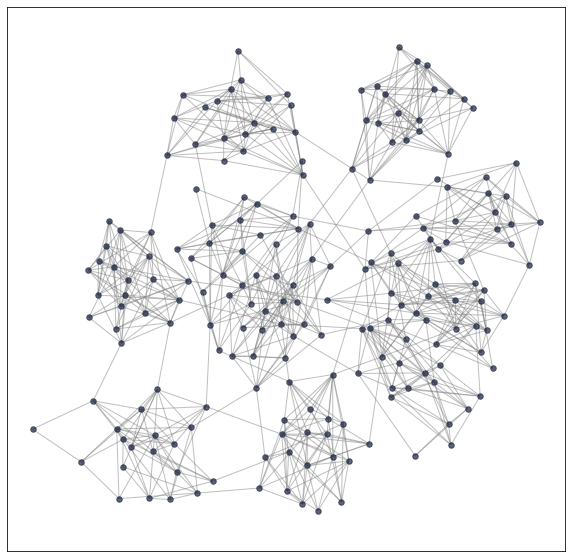

<IPython.core.display.Javascript object>

In [26]:
import networkx as nx
import random


G = nx.random_partition_graph([20 for x in range(10)], 0.4,0.002)


mapping = dict(zip(G, range(0,len(G))))
G = nx.relabel_nodes(G, mapping)

positions = nx.kamada_kawai_layout(G)
position_array = np.array([positions[x] for x in positions])

fig, ax =plt.subplots(figsize=(10,10))
nx.draw_networkx_nodes(G, positions, node_size=30,node_color="#1a2340", alpha=0.7)
nx.draw_networkx_edges(G, positions, edge_color="grey", alpha=0.5)
plt.axis('equal')


#### Random Geometric Graph

(-1.0490203118015096,
 1.0975723958000718,
 -1.0748268995720804,
 1.0798247202376114)

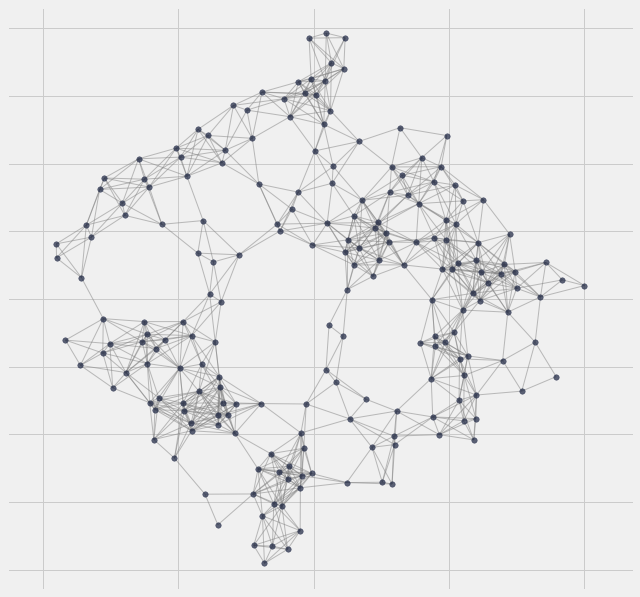

<IPython.core.display.Javascript object>

In [98]:
n = 200
G = nx.random_geometric_graph(n, 0.13)

mapping = dict(zip(G, range(0, len(G))))
G = nx.relabel_nodes(G, mapping)

positions = nx.kamada_kawai_layout(G)
position_array = np.array([positions[x] for x in positions])

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_nodes(G, positions, node_size=30, node_color="#1a2340", alpha=0.7)
nx.draw_networkx_edges(G, positions, edge_color="grey", alpha=0.5)
plt.axis("equal")

In [104]:
class MultiAgentActivation(BaseScheduler):
    """Broken out from mesa, same as random activation.
    We might want to mess with this later..."""

    def step(self) -> None:
        """Executes the step of all agents, one at a time, in
        random order.
        """
        for agent in self.agent_buffer(shuffled=True):
            agent.step()
        self.steps += 1
        self.time += 1


class MyAgent(Agent):

    """An agent for a mesa simulation.

    Attributes:
        alive (bool): is the agent alive? (currently unused.)
        gathered_utility (int): How much payoff has the agent gathered in the games it has played so far?
        probability_team_reasoning (float or int): Number between 0 and one: How likely is an agent to
            team-reason, given that they are a team-reasoner.
        team_reasoner (bool): Is the agent a team-reasoner?
        team_reasoning_counter (int): How often has the agent engaged in team reasoning so far.
    """

    def __init__(
        self, unique_id, model, team_reasoner=False, probability_team_reasoning=0.9
    ):
        """Constructor method"""
        super().__init__(unique_id, model)

        self.team_reasoner = team_reasoner
        self.alive = True
        self.gathered_utility = 0
        self.probability_team_reasoning = probability_team_reasoning
        self.team_reasoning_counter = 0

    def step(self):
        """Step function for the agents: First we choose another neighboring agent to play with. Both agents then reason
        about the game, and play accordingly. Finally the current agent collects their payoff, depending on the
        outcome."""

        my_neighbors_ids = list(
            self.model.interaction_network.neighbors(self.unique_id)
        )

        other_player = self.model.schedule.agents[random.choice(my_neighbors_ids)]

        #         print(other_player.unique_id)
        # self.random.choice(self.model.schedule.agents)
        choices = [
            self.reason(
                player,
                player.probability_team_reasoning,
            )
            for player in [self, other_player]
        ]
        payoff = self.model.game.return_payoffs(
            [x + 1 for x in choices]
        )  # the +1 part is super hacky, it's because choices currently start at 1.
        self.gathered_utility += payoff[0]

        # Did the opponent do, what I would have done if I were a team-reasoner?
        opponent_team_reasoned = (
            self.model.game.return_team_reasoners_choice() == choices[1]
        )

        self.probability_team_reasoning = (
            (self.probability_team_reasoning * self.model.this_step)
            + int(opponent_team_reasoned)
        ) / (self.model.this_step + 1)

        pass

    def reason(self, player, probability_team_reasoning):
        """Reasoning function, in which the players determine their played strategy, given the game
        and whether they are team-reasoners. This currently hard-codes the prisoners dilemma, but
        in the future might be combined with a general solver for team-reasoning, maybe making use of nashpy.

        Args:
            player (MyAgent): An agent of class MyAgent.
            game (game): A game implemented according to our game-syntax.
        Returns:
            list: A strategy to be used in nashpy.
        """
        if player.team_reasoner == True:

            if np.random.rand() < player.probability_team_reasoning:
                if player == self:
                    self.team_reasoning_counter += 1
                return self.model.game.return_team_reasoners_choice()
            else:
                return self.model.game.return_non_trs_choice()
        else:
            return self.model.game.return_non_trs_choice()


class MyModel(Model):
    """
    Attributes:
        datacollector (mesa datacollector): A mesa datacollector object ( defined internally)
        game (nashpy): a naspy-game which the actors play. (This might be later updated with the
            use of a dictionary, for multiple games.)
        n_agents (int): The number of agents.
        probability_team_reasoning (float or int): The probability that team-reasoning actors actually team reason. Between 0 and 1.
        proportion_team_reasoners (float or int): The share of team reasoners. Between 0 and 1. The actual share in the simulation
            will be rounded, depending on the number of agents in the simulation.
        schedule (mesa schedule): The stack of agents used internally by mesa.
        utility_calculation (str): How utilities for the replicator dynamic will be calculated. Either "empirical_average", using
            the actually collected payoffs from the last round, or "expected_utility", using the distribution of team-reasoners
            and the expected payoffs of the game(currently hardcoded!) as a base.
            The latter approach is faithful to Armadae and Lempert, 2015, and le.ads (qualitatively) to a smoother dynamic
    """

    def __init__(
        self,
        proportion_team_reasoners,
        n_agents,
        init_network,
        game,
        probability_team_reasoning,
        utility_calculation="empirical_average",
    ):
        """constructor class"""
        super().__init__()

        self.n_agents = n_agents
        self.schedule = MultiAgentActivation(self)
        self.game = game
        self.probability_team_reasoning = probability_team_reasoning
        self.make_n_agents(self.n_agents, proportion_team_reasoners)
        self.proportion_team_reasoners = proportion_team_reasoners
        self.utility_calculation = utility_calculation
        self.this_step = 0

        if isinstance(init_network, nx.classes.graph.Graph):
            if len(list(init_network.nodes)) != self.n_agents:
                raise Exception(
                    "The number of nodes in the input-graph doesn't match up with the passed n_agents."
                )
            else:
                self.interaction_network = init_network
        #
        agent_reporters = {
            "team_reasoner": lambda a: getattr(a, "team_reasoner", None),
            "probability_team_reasoning": lambda a: getattr(
                a, "probability_team_reasoning", None
            ),
            "gathered_utility": lambda a: getattr(a, "gathered_utility", None),
            "alive": lambda a: getattr(a, "alive", None),
            "team_reasoning_counter": lambda a: getattr(
                a, "team_reasoning_counter", None
            ),
        }

        model_reporters = {
            "proportion_team_reasoners": lambda a: getattr(
                a, "proportion_team_reasoners", None
            ),
        }

        self.datacollector = DataCollector(
            model_reporters=model_reporters, agent_reporters=agent_reporters
        )

    def make_n_agents(self, n_agents, proportion_team_reasoners, starting_no=0):
        """A helper function to set up a number of agents. Used at init and every step of the model.

        Args:
            n_agents (int): Number of agents.
            proportion_team_reasoners (float or int): The share of team reasoners. Between 0 and 1. The actual share in the simulation
                will be rounded, depending on the number of agents in the simulation.
            starting_no (int, optional): Number at which to start the unique id's of the agents.
                Necessary to adjust upwards when adding agents, so that earlier agents are not overwritten.
        """
        team_reason_until = int(proportion_team_reasoners * n_agents)
        for ix, i in enumerate(range(self.n_agents)):
            if ix < team_reason_until:
                a = MyAgent(
                    unique_id=i + starting_no,
                    model=self,
                    team_reasoner=True,
                    probability_team_reasoning=self.probability_team_reasoning,
                )
            else:
                a = MyAgent(
                    unique_id=i + starting_no,
                    model=self,
                    team_reasoner=False,
                    probability_team_reasoning=self.probability_team_reasoning,
                )

            self.schedule.add(a)

    def step(self):
        self.this_step += 1
        self.schedule.step()
        self.datacollector.collect(self)


#

model = MyModel(
    proportion_team_reasoners=0.85,
    n_agents=200,
    init_network=G,
    game=prisoners_dilemma,
    probability_team_reasoning=0.7,
    utility_calculation="expected_utility",
)


# expected_utility
for t in tqdm.tqdm_notebook(range(300)):
    model.step()

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:216: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/300 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [105]:
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()


<IPython.core.display.Javascript object>

In [106]:
agent_df = agent_df.reset_index()

<IPython.core.display.Javascript object>

In [107]:
agent_df

,Step,AgentID,team_reasoner,probability_team_reasoning,gathered_utility,alive,team_reasoning_counter
0,1,0,True,0.350000,1,True,1
1,1,1,True,0.850000,3,True,1
2,1,2,True,0.350000,2,True,0
3,1,3,True,0.850000,3,True,1
4,1,4,True,0.850000,3,True,1
...,...,...,...,...,...,...,...
59995,300,195,False,0.118605,670,True,0
59996,300,196,False,0.258140,754,True,0
59997,300,197,False,0.218272,730,True,0
59998,300,198,False,0.404319,842,True,0


<IPython.core.display.Javascript object>

(-1.0490203118015096,
 1.0975723958000718,
 -1.0748268995720807,
 1.079824720237611)

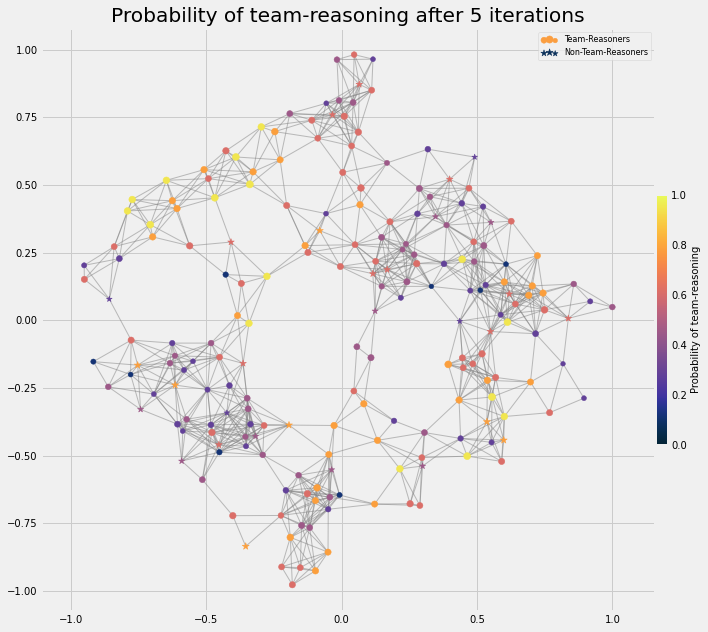

<IPython.core.display.Javascript object>

In [111]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax =plt.subplots(figsize=(10,10))

step_to_plot = 5
plt.title(
    "Probability of team-reasoning after "
    + str(step_to_plot)
    + " iterations"
)
final_agent_df = agent_df[agent_df["Step"] == step_to_plot]



trs = final_agent_df["team_reasoner"]
nx.draw_networkx_edges(G, positions, edge_color="grey", alpha=0.5)



tr_scatter= plt.scatter(position_array[trs,0],
            position_array[trs,1], s= final_agent_df['gathered_utility'][trs] *3,
            c=final_agent_df['probability_team_reasoning'][trs],
            cmap=cmocean.cm.thermal,
            vmin=0, vmax=1
            
           )

non_tr_scatter = plt.scatter(position_array[~trs,0],
            position_array[~trs,1],  s= final_agent_df['gathered_utility'][~trs] *3
            , marker = '*',
           c=final_agent_df['probability_team_reasoning'][~trs],cmap=cmocean.cm.thermal,
            vmin=0, vmax=1
           
           )

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
   
cbar = plt.colorbar(tr_scatter,fraction=0.02, pad=0.0)
cbar.set_label('Probability of team-reasoning',fontsize=10)
cbar.ax.tick_params(labelsize=10)
ax.tick_params(labelsize=10)



plt.legend((tr_scatter,non_tr_scatter),
           ('Team-Reasoners','Non-Team-Reasoners'),
           scatterpoints=3,
           loc='upper right',
           ncol=1,
           fontsize=8)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('#fb9e40')
leg.legendHandles[1].set_color('#092f59')



plt.axis('equal')


Text(0.5, 1.0, 'Probability of team-reasoning over 300 iterations of Prisoners Dilemma')

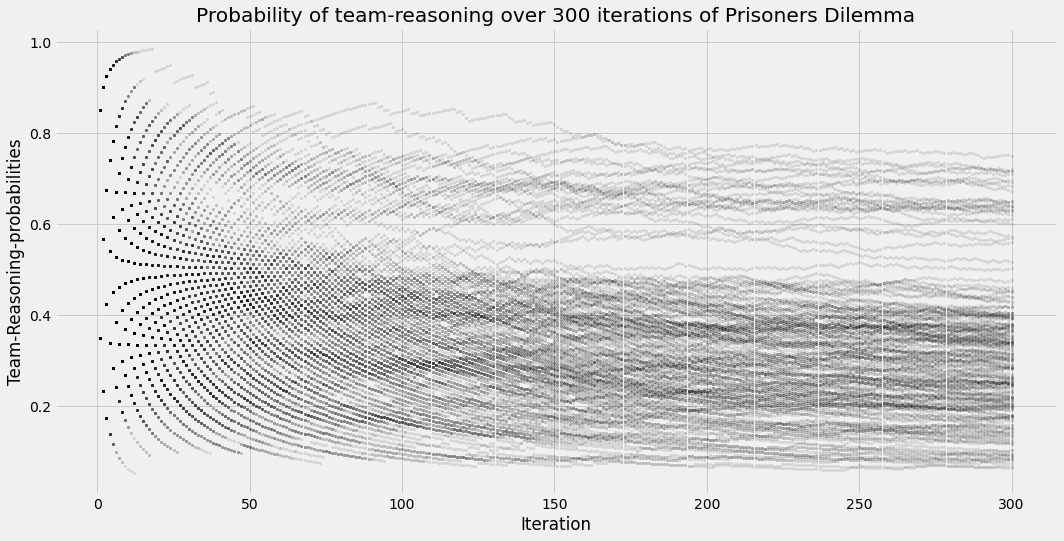

<IPython.core.display.Javascript object>

In [109]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use("fivethirtyeight")  # opinions.mplstyle")

# total_amount_of_agents = agent_df.groupby("Step")["alive"].sum()
# total_amount_of_team_reasoners = agent_df.groupby("Step")["team_reasoner"].sum()

# plt.plot(
#     [y / x for x, y in zip(total_amount_of_agents, total_amount_of_team_reasoners)],
#     linewidth=1.6,
#     c="#ab0b00",
#     alpha=1,
# )

plt.scatter(
    x=agent_df["Step"],
    y=agent_df["probability_team_reasoning"],
    c="black",
    s=6,
    alpha=0.1,
)
# probability_team_reasoning
plt.xlabel("Iteration")
plt.ylabel("Team-Reasoning-probabilities")
plt.title(
    "Probability of team-reasoning over "
    + str(np.max(agent_df["Step"]))
    + " iterations of Prisoners Dilemma"
)

Text(0.5, 1.0, 'Probability of team-reasoning over 300 iterations of Prisoners Dilemma')

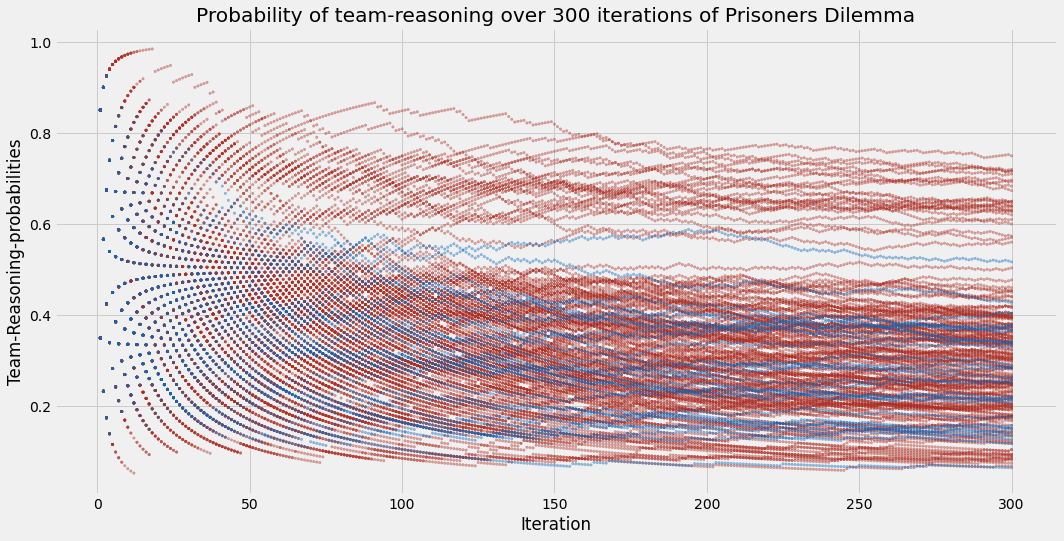

<IPython.core.display.Javascript object>

In [110]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use("fivethirtyeight")  # opinions.mplstyle")

# total_amount_of_agents = agent_df.groupby("Step")["alive"].sum()
# total_amount_of_team_reasoners = agent_df.groupby("Step")["team_reasoner"].sum()

# plt.plot(
#     [y / x for x, y in zip(total_amount_of_agents, total_amount_of_team_reasoners)],
#     linewidth=1.6,
#     c="#ab0b00",
#     alpha=1,
# )

plt.scatter(
    x=agent_df["Step"],
    y=agent_df["probability_team_reasoning"],
    c=agent_df["team_reasoner"].astype(int),
    s=6,
    alpha=0.4,
    cmap=cmocean.cm.balance,
    edgecolors=None,
    vmax=1.3,
    vmin=-0.3,
)
# probability_team_reasoning
plt.xlabel("Iteration")
plt.ylabel("Team-Reasoning-probabilities")
plt.title(
    "Probability of team-reasoning over "
    + str(np.max(agent_df["Step"]))
    + " iterations of Prisoners Dilemma"
)

***Nothing new beyond this point!***

# Varying parameters

We run two nested for loops, in which we try out every combination of parameters.

## Todo:
* find a cleaner way of doing this, eg by using a parameter dictionary. Or maybe scikit gridsearch?
* It would also be nice to start thinking about automatic report generation. (Graphics + parameter.md + latex template) -> pandoc -> pdf ? 
* Also think about non-rectangular grids (?).

In [24]:
collected_results = []
run_no = 0
for proportion_of_team_reasoners in tqdm.tqdm_notebook(np.linspace(0.05, 0.95, 31)):
    for probability_team_reasoning in tqdm.tqdm_notebook(np.linspace(0, 1, 31)):

        model = MyModel(
            proportion_team_reasoners=proportion_of_team_reasoners,
            n_agents=200,
            game=prisoners_dilemma,
            probability_team_reasoning=probability_team_reasoning,
            utility_calculation="empirical_average",
        )

        for t in range(70):
            try:
                model.step()
            except:
                break
        model_df = model.datacollector.get_model_vars_dataframe()
        agent_df = model.datacollector.get_agent_vars_dataframe()
        agent_df = agent_df.reset_index()

        agent_df["run_no"] = run_no
        agent_df["proportion_team_reasoners"] = proportion_of_team_reasoners
        agent_df["probability_team_reasoning"] = probability_team_reasoning

        collected_results.append(
            agent_df
        )  # this is not memory-friendly in the long run...
        run_no += 1

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [25]:
collected_frame = pd.concat(collected_results)

<IPython.core.display.Javascript object>

We now run over every collected dataset and extract the variables of interest to us. These are:
* sum of gathered utility by type (not very sensible)
* survival: How long it takes for the team-reasoners to die of. (`drops_under_two`, or `final_step`, if the simulations end with errors.


In [26]:
grouped = collected_frame.groupby(["run_no", "team_reasoner"])[
    "gathered_utility"
].sum()
grouped = pd.DataFrame(grouped).reset_index()
display(grouped)
grouped = grouped.groupby("run_no")


# This seems like somewhat unprincipled code which ought to be cleaned up in the future.
diff_frames = []
for name, group in grouped:
    diff_frame =  pd.DataFrame(collected_frame[collected_frame["run_no"] == name].iloc[0]).T[
            ["run_no", "proportion_team_reasoners", "probability_team_reasoning"]
        ]
    performance_diff = (
        group[group["team_reasoner"] == False]["gathered_utility"].iloc[0]
        - group[group["team_reasoner"] == True]["gathered_utility"].iloc[0]
    )
    diff_frame['performance_diff'] = performance_diff
    
    diff_frame['amount_of_steps'] = np.max(collected_frame[collected_frame["run_no"] == name]['Step'])
    run_frame = pd.DataFrame(collected_frame[collected_frame["run_no"] == name])
    
    share_team = []
    for this_step in range(np.max(run_frame['Step'])):
        final_step = run_frame[run_frame['Step'] == this_step]
        share_tr = len(final_step[final_step['team_reasoner'] ==True])
        share_team.append(share_tr)
        drops_under_two = len([x>=2 for x in share_team])
        diff_frame['drops_under_two'] = drops_under_two
    
    diff_frames.append(diff_frame)


,run_no,team_reasoner,gathered_utility
0,0,False,26600
1,0,True,1400
2,1,False,26934
3,1,True,1084
4,2,False,27504
...,...,...,...
1917,958,True,4756
1918,959,False,5108
1919,959,True,4673
1920,960,False,5206


<IPython.core.display.Javascript object>

In [27]:
difference_frame = pd.concat(diff_frames)

<IPython.core.display.Javascript object>

In [28]:
difference_frame

,run_no,proportion_team_reasoners,probability_team_reasoning,performance_diff,amount_of_steps,drops_under_two
0,0,0.05,0,25200,70,70
0,1,0.05,0.0333333,25850,70,70
0,2,0.05,0.0666667,26993,70,70
0,3,0.05,0.1,12949,34,34
0,4,0.05,0.133333,9174,24,24
...,...,...,...,...,...,...
0,956,0.95,0.866667,1527,23,23
0,957,0.95,0.9,930,21,21
0,958,0.95,0.933333,670,21,21
0,959,0.95,0.966667,435,20,20


<IPython.core.display.Javascript object>

### Difference in utilities
As a first measure of performance we look at the summed difference between the utilities collected by team-reasoners and non-team-reasoners. This is not a good metric and basically only tells us who survives until the end. **Improvements welcome!**

Text(0.5, 0, 'Sum of utility: non-TR - TR')

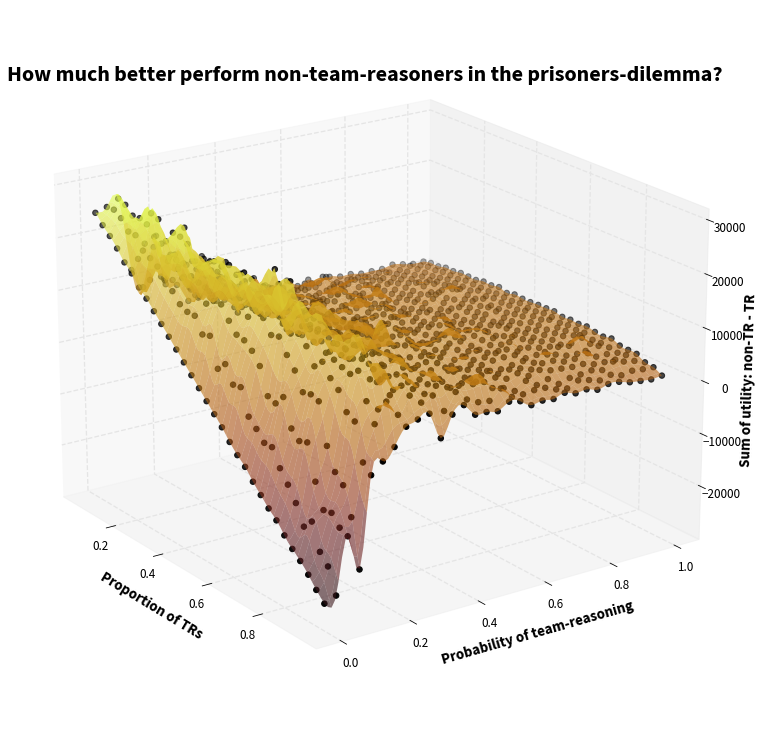

<IPython.core.display.Javascript object>

In [29]:
plt.style.use("opinions.mplstyle")
fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)
ax.view_init(20,-35)



spline = scipy.interpolate.Rbf(difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["performance_diff"],function='multiquadric')#,smooth=1)#, epsilon=2)

x_grid = np.linspace(np.min(difference_frame["proportion_team_reasoners"]), np.max(difference_frame["proportion_team_reasoners"]),100)
y_grid = np.linspace(np.min(difference_frame["probability_team_reasoning"]), np.max(difference_frame["probability_team_reasoning"]),100)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = spline(B1,B2)

ax.plot_surface(B1, B2, Z,alpha=.6,cmap=cmocean.cm.solar)
ax.scatter(
    difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["performance_diff"],
    s=30,c='black'#,alpha= 1
)

plt.title("How much better perform non-team-reasoners in the prisoners-dilemma?",y=.87)


plt.xlabel("Proportion of TRs", labelpad=10)
plt.ylabel("Probability of team-reasoning", labelpad=10)
ax.set_zlabel("Sum of utility: non-TR - TR")
# ax.invert_xaxis()



Text(186.14000000000016, 1, 'Probability of team-reasoning')

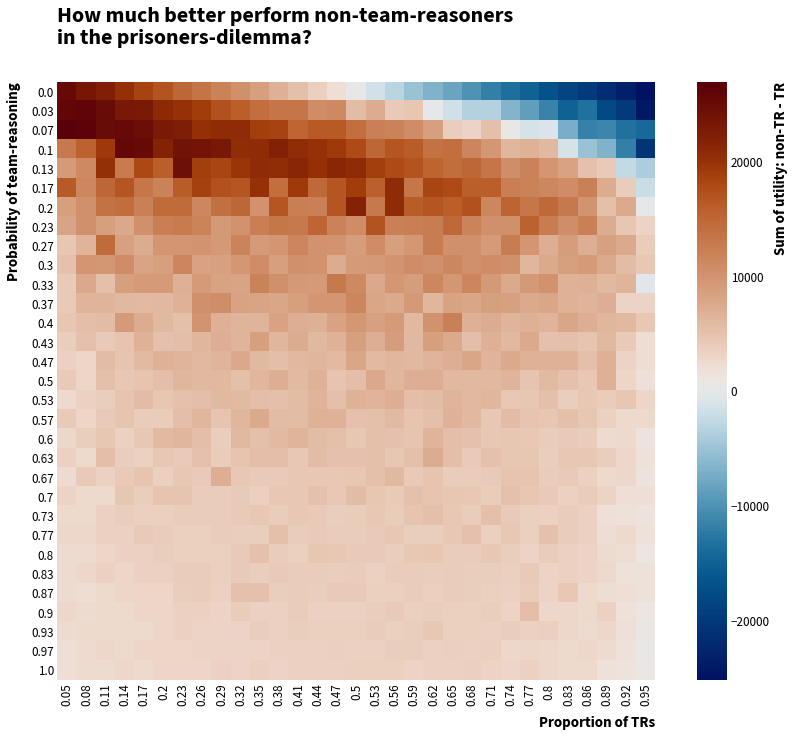

<IPython.core.display.Javascript object>

In [30]:
fig = plt.figure(figsize=(15, 11))
plt.title("How much better perform non-team-reasoners \nin the prisoners-dilemma?",y=1.03)

to_plot = difference_frame.pivot_table(
    index="probability_team_reasoning",
    columns="proportion_team_reasoners",
    values="performance_diff",
)


sns.heatmap(to_plot,cmap=cm.vik,fmt='.3f',xticklabels=to_plot.columns.values.round(2),yticklabels=to_plot.index.values.round(2),
            cbar_kws={'label':'Sum of utility: non-TR - TR'}, square = True)

plt.xlabel("Proportion of TRs", labelpad=10)
plt.ylabel("Probability of team-reasoning", labelpad=10)


### Length of simulation
We can also check how many steps it takes for the ratio of team-reasoners to drop under 2 %, which gives an indirect measure of their success. 

Text(0.5, 0, 'Number of TRs < 2 at step')

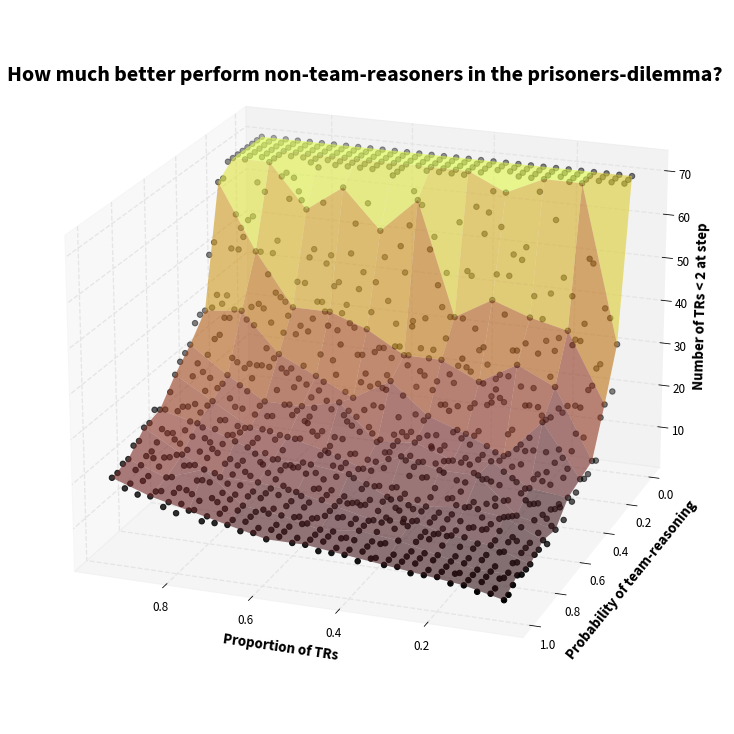

<IPython.core.display.Javascript object>

In [31]:
plt.style.use("opinions.mplstyle")
fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)
ax.view_init(20,110)

import cmocean


spline = scipy.interpolate.Rbf(difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["drops_under_two"])#,function='multiquadric')#,smooth=1)#, epsilon=2)

x_grid = np.linspace(np.min(difference_frame["proportion_team_reasoners"]), np.max(difference_frame["proportion_team_reasoners"]),11)
y_grid = np.linspace(np.min(difference_frame["probability_team_reasoning"]), np.max(difference_frame["probability_team_reasoning"]),11)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = spline(B1,B2)

ax.plot_surface(B1, B2, Z,alpha=.6,cmap=cmocean.cm.solar)
ax.scatter(
    difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["drops_under_two"],
    s=30,c='black'#,alpha= 1
)

plt.title("How much better perform non-team-reasoners in the prisoners-dilemma?",y=.87)


plt.xlabel("Proportion of TRs", labelpad=10)
plt.ylabel("Probability of team-reasoning", labelpad=10)
ax.set_zlabel("Number of TRs < 2 at step")
# ax.invert_xaxis()



Text(186.14000000000016, 1, 'Probability of team-reasoning')

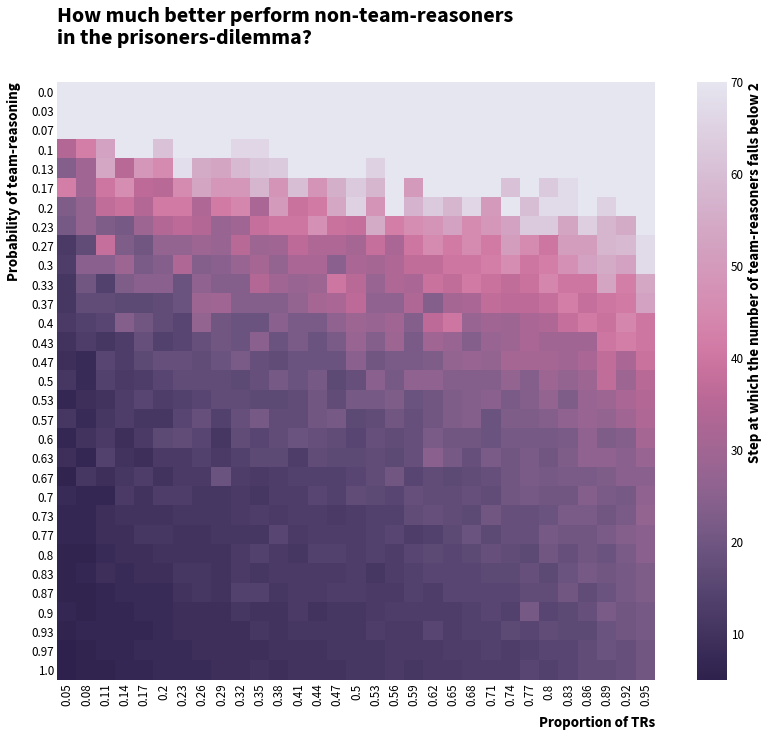

<IPython.core.display.Javascript object>

In [32]:


fig = plt.figure(figsize=(15, 11))
plt.title("How much better perform non-team-reasoners \nin the prisoners-dilemma?",y=1.03)

to_plot = difference_frame.pivot_table(
    index="probability_team_reasoning",
    columns="proportion_team_reasoners",
    values="drops_under_two",
)


sns.heatmap(to_plot,cmap=cm.acton,fmt='.3f',xticklabels=to_plot.columns.values.round(2),yticklabels=to_plot.index.values.round(2),
            cbar_kws={'label':'Step at which the number of team-reasoners falls below 2'}, square = True)

plt.xlabel("Proportion of TRs", labelpad=10)
plt.ylabel("Probability of team-reasoning", labelpad=10)


## Literature

Amadae, S. M., & Lempert, D. (2015). The long-term viability of team reasoning. Journal of Economic Methodology, 22(4), 462–478. https://doi.org/10.1080/1350178X.2015.1024880

Kazil, J., Masad, D., & Crooks, A. (2020). Utilizing Python for Agent-Based Modeling: The Mesa Framework. In R. Thomson, H. Bisgin, C. Dancy, A. Hyder, & M. Hussain (Eds.), Social, Cultural, and Behavioral Modeling (pp. 308–317). Springer International Publishing. https://doi.org/10.1007/978-3-030-61255-9_30

Knight, V., & Campbell, J. (2018). Nashpy: A Python library for the computation of Nash equilibria. Journal of Open Source Software, 3(30), 904. https://doi.org/10.21105/joss.00904


In [47]:
!git add .\team_reasoning_in_prisoners_full_replacement_replicator_dyn.ipynb
# !git add .\tree.png

!git commit -m "general cleanup & some documentation added..."
!git push -u origin main -f


[main 0d91fdd] general cleanup & some documentation added...
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 tree.png
Branch main set up to track remote branch main from origin.


To https://github.com/MNoichl/simple_teams.git
   247fd34..0d91fdd  main -> main


<IPython.core.display.Javascript object>

In [ ]:
    def step(self):
        """Step function of the model. It first lets all the agents play according to their step-functions. Then it collects
        the resulting data. Afterwards it determines the new ratio of team-reasoners, according to the given method,
        and sets up a new population of agents with the respective share.
        """
        # Run model & collect data:
        self.schedule.step()
        self.datacollector.collect(self)

        #  Determine current share of team-reasoners:
        actual_proportion_team_reasoners = (
            self.proportion_team_reasoners
        )  # why does it work this way?

        # to use empirical payoffs:
        if self.utility_calculation == "empirical_average":

            replication_frame = pd.DataFrame(
                [
                    [agent.gathered_utility for agent in model.schedule.agents],
                    [agent.team_reasoner for agent in model.schedule.agents],
                ]
            ).T

            replication_frame.columns = ["gathered_utility", "team_reasoner"]

            ratio_dict = dict(
                pd.to_numeric(replication_frame["gathered_utility"])
                .groupby(replication_frame["team_reasoner"])
                .mean()
            )
            #             print(ratio_dict)
            non_tr_utils = ratio_dict.get(False)
            tr_utils = ratio_dict.get(True)

        elif self.utility_calculation == "expected_utility":
            #         to use expected payoff:
            non_tr_utils = (
                1 - actual_proportion_team_reasoners
            ) * 2 + actual_proportion_team_reasoners * 4  # change to nash
            tr_utils = (
                1 - actual_proportion_team_reasoners
            ) * 1 + actual_proportion_team_reasoners * 3  # change to nas

        #         average_utility = pd.to_numeric(replication_frame["gathered_utility"]).mean()
        delta_share = (
            actual_proportion_team_reasoners
            * (1 - actual_proportion_team_reasoners)
            * (
                (non_tr_utils - tr_utils)
                / (
                    (actual_proportion_team_reasoners * tr_utils)
                    + ((1 - actual_proportion_team_reasoners) * non_tr_utils)
                )
            )
        )

        new_tr_share = actual_proportion_team_reasoners - delta_share

        max_id = np.max([agent.unique_id for agent in model.schedule.agents])

        for agent in model.schedule.agents:
            self.schedule.remove(agent)

        self.make_n_agents(self.n_agents, new_tr_share, max_id + 1)
        self.proportion_team_reasoners = new_tr_share

